# Optimizer Testbed

#### This notebook tests optimization algorithms

Tasks
0. MNIST classification (CNN)
0. CIFAR-10 classification (CNN)
0. MNIST GAN?

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD']


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


## MNIST classification

Load data

In [2]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Build model:

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


Train the model, plotting both train and test loss.

In [4]:
# First define a callback to record train and test loss on each minibatch
from keras.callbacks import Callback


class minibatch_History(Callback):
    """Callback that records events into a `History` object.
    
    Predicts over the validation set and each input batch (w/o dropout) 
    after each batch.

    """
    def __init__(self, count_mode='samples', Nevery = 1):
        super(minibatch_History, self).__init__()
        self.Nevery = Nevery
            
    
    def on_train_begin(self, logs=None):
        self.batch = []
        self.history = {'val_loss':list(),
                        'val_acc':list()}
        self.batch_no = 0
        self.target = self.params['samples']
        
    def on_batch_end(self, batch, logs=None):
        if self.batch_no % self.Nevery == 0 or self.batch_no == self.target:
            logs = logs or {}
            self.batch.append(batch)
            for k, v in logs.items():
                self.history.setdefault(k, []).append(v)

            # add validation loss. Only test on a random subset of minibatch size
            val_loss, val_acc =  self.model.evaluate(self.validation_data[0], 
                                                     self.validation_data[1], verbose=0)   
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)


In [5]:
batch_size = 128
epochs = 10
nb_train = 10000
nb_test = 1000

hist = minibatch_History(Nevery = 20)

model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[hist])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
4s - loss: 0.8785 - acc: 0.7274 - val_loss: 0.3713 - val_acc: 0.8740
Epoch 2/10
4s - loss: 0.3110 - acc: 0.9073 - val_loss: 0.1986 - val_acc: 0.9400
Epoch 3/10
4s - loss: 0.2208 - acc: 0.9360 - val_loss: 0.1838 - val_acc: 0.9400
Epoch 4/10
4s - loss: 0.1716 - acc: 0.9515 - val_loss: 0.1245 - val_acc: 0.9570
Epoch 5/10
4s - loss: 0.1407 - acc: 0.9600 - val_loss: 0.1062 - val_acc: 0.9650
Epoch 6/10
4s - loss: 0.1267 - acc: 0.9626 - val_loss: 0.0948 - val_acc: 0.9710
Epoch 7/10
4s - loss: 0.1070 - acc: 0.9686 - val_loss: 0.0948 - val_acc: 0.9720
Epoch 8/10
4s - loss: 0.0949 - acc: 0.9704 - val_loss: 0.0873 - val_acc: 0.9700
Epoch 9/10
4s - loss: 0.0827 - acc: 0.9744 - val_loss: 0.0831 - val_acc: 0.9720
Epoch 10/10
4s - loss: 0.0774 - acc: 0.9766 - val_loss: 0.0814 - val_acc: 0.9730
Test loss: 0.0752423943387
Test accuracy: 0.9758


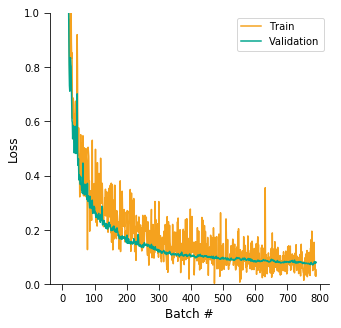

In [6]:
plt.figure(figsize=(5,5))
simpleaxis(plt.gca())

batch_no = np.arange(np.array(hist.history['loss']).shape[0])
plt.plot(batch_no,hist.history['loss'],color=colors[0])
plt.plot(batch_no,hist.history['val_loss'],color=colors[1])
plt.legend(['Train','Validation'],loc=0)
plt.xlabel('Batch #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.ylim((0,1));

Note that the the training loss is higher because it is calculated from the net in training, which has dropout instantiated. TODO change the callback so this prints the actual loss.

## Test GraVa

In [7]:
gr_model = Sequential()
gr_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
gr_model.add(Conv2D(64, (3, 3), activation='relu'))
gr_model.add(MaxPooling2D(pool_size=(2, 2)))
gr_model.add(Dropout(0.25))
gr_model.add(Flatten())
gr_model.add(Dense(128, activation='relu'))
gr_model.add(Dropout(0.5))
gr_model.add(Dense(num_classes, activation='softmax'))


opt = keras.optimizers.GraVa(lr=0.001, beta_1=0.9, beta_2=0.999, var_care=1, decay=0.0)
gr_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
batch_size = 128
epochs = 10
nb_train = 10000
nb_test = 1000

gr_hist = minibatch_History(Nevery = 20)

gr_model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[gr_hist])
score = gr_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
4s - loss: 2.3128 - acc: 0.0977 - val_loss: 2.3059 - val_acc: 0.0830
Epoch 2/10
4s - loss: 2.3050 - acc: 0.1057 - val_loss: 2.2974 - val_acc: 0.1050
Epoch 3/10
4s - loss: 2.2962 - acc: 0.1207 - val_loss: 2.2867 - val_acc: 0.1430
Epoch 4/10
4s - loss: 2.2840 - acc: 0.1383 - val_loss: 2.2742 - val_acc: 0.1850
Epoch 5/10
4s - loss: 2.2709 - acc: 0.1629 - val_loss: 2.2597 - val_acc: 0.2390
Epoch 6/10
4s - loss: 2.2581 - acc: 0.1868 - val_loss: 2.2433 - val_acc: 0.3030
Epoch 7/10
4s - loss: 2.2359 - acc: 0.2349 - val_loss: 2.2240 - val_acc: 0.3720
Epoch 8/10
4s - loss: 2.2181 - acc: 0.2536 - val_loss: 2.2013 - val_acc: 0.4440
Epoch 9/10
4s - loss: 2.1938 - acc: 0.2830 - val_loss: 2.1740 - val_acc: 0.5030
Epoch 10/10
4s - loss: 2.1635 - acc: 0.3191 - val_loss: 2.1409 - val_acc: 0.5270
Test loss: 2.12359971237
Test accuracy: 0.5673


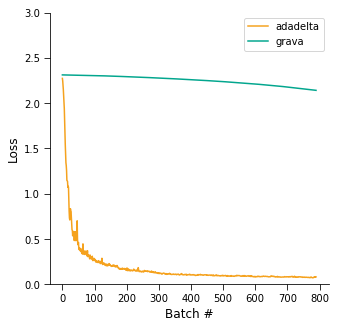

In [13]:
plt.figure(figsize=(5,5))
simpleaxis(plt.gca())

batch_no = np.arange(np.array(hist.history['loss']).shape[0])
plt.plot(batch_no,hist.history['val_loss'],color=colors[0])
plt.plot(batch_no,gr_hist.history['val_loss'],color=colors[1])
plt.legend(['adadelta','grava'],loc=0)
plt.xlabel('Batch #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.ylim((0,3));

#### Now optimize parameters to see if we can improve this horrid performance

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4rf = {
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e2)),
    'var_care': hp.loguniform('var_care', np.log(1e-5),np.log(1e2)), 
}

trials = Trials()

def fnc(params):
    lr = params['lr']
    var_care = params['var_care']
    
    
    gr_model = Sequential()
    gr_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    gr_model.add(Conv2D(64, (3, 3), activation='relu'))
    gr_model.add(MaxPooling2D(pool_size=(2, 2)))
    gr_model.add(Dropout(0.25))
    gr_model.add(Flatten())
    gr_model.add(Dense(128, activation='relu'))
    gr_model.add(Dropout(0.5))
    gr_model.add(Dense(num_classes, activation='softmax'))


    opt = keras.optimizers.GraVa(lr=lr, beta_1=0.99, beta_2=0.99, var_care=var_care, decay=0.0)
    gr_model.compile(loss=keras.losses.categorical_crossentropy,
                                   optimizer=opt,
                                      metrics=['accuracy'])
    
    gr_model.fit(x_train[:10000], y_train[:10000],
          batch_size=32,
          epochs=10,
          verbose=0,
          
          validation_data=(x_test[:1000], y_test[:1000]))
    score = gr_model.evaluate(x_test, y_test, verbose=0)
    print(score, params)
    return {'loss':score[0], 'status': STATUS_OK }

hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=50, trials=trials)

    

[0.20149210471212864, 0.94079999999999997] {'var_care': 1.8710515149091338, 'lr': 0.006130850512544901}
[1.8405439571380615, 0.72670000000000001] {'var_care': 5.244779698526706, 'lr': 0.00020953708995017191}
[14.299974133300781, 0.1128] {'var_care': 0.3128975891087673, 'lr': 33.82060947000845}
[2.1005243438720704, 0.59319999999999995] {'var_care': 1.0292119544888165, 'lr': 0.00017214631090061312}
[2.2652325538635254, 0.20899999999999999] {'var_care': 26.58089980904335, 'lr': 6.380758452880467e-05}
[2.2483019554138184, 0.28860000000000002] {'var_care': 0.32755837469538673, 'lr': 9.197069686950193e-05}
[0.12890246709436179, 0.96230000000000004] {'var_care': 3.9820535667306634, 'lr': 0.017127521770125425}
[2.3016370029449464, 0.1135] {'var_care': 0.018610319997188807, 'lr': 0.18950815302215726}
[0.080755256762588393, 0.9748] {'var_care': 0.008540842986253062, 'lr': 0.028414015227342125}
[0.070577877296844962, 0.97689999999999999] {'var_care': 0.03076808202324525, 'lr': 0.15327350893201955

## Plot computational graphs

Train a simple 2 layer linear net on a simple problem. Print the computation graph to error check.

We'll be using TensorBoard, since it's awesome. This will print the log file for tensorboard; to see the graph and metrics you'll have to open the log in standalone tensorboard.

Note that this requires us to be using tf as the backend.

In [9]:
# function: z = exp(-x^2 -y^2)

x = np.random.normal(size = (1000,2))
z = np.exp(-x[:,1]**2 -x[:,0]**2)

x_test = np.random.normal(size = (100,2))
z_test = np.exp(-x_test[:,1]**2 -x_test[:,0]**2)


In [10]:
small_model = Sequential()

small_model.add(Dense(2, activation='linear',input_shape=(2,)))
small_model.add(Dense(1, activation='linear'))

opt = keras.optimizers.SGD()
small_model.compile(loss=keras.losses.mean_squared_error,
              optimizer=opt)


In [11]:
# for tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

small_model.fit(x,z,
          batch_size=10,
          epochs=10,
          verbose=0,
          validation_data=(x_test, z_test),
          callbacks=[tbCallBack])

RuntimeError: TensorBoard callback only works with the TensorFlow backend.

In [ ]:
# x = np.array([[[1,2], [2,2]], [[3,2], [4,2]]])
# y = np.array([[[5,2], [6,2]], [[7,2], [8,2]]])

x = np.ones((30,2,3))
y = x

print(np.sum(np.multiply(x,y)))

x = K.constant(x)
y = K.constant(y)

K.eval(K.sum(keras.backend.batch_dot(x,y,axes=(0,9)),axis=0))

In [ ]:
x = np.array([[1, 2], [3, 4]])
y = np.array([[5, 6], [7, 8]])

np.sum(np.multiply(x,y))

## Plot gradients
#### As a function of inputs, and as a function of batch/epoch